In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-01-24 11:06:48.091472: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 11:06:48.736464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-24 11:06:48.736544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-24 11:06:48.736553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Max mutual information vs sampling density for different samples

In [2]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
num_bootstrap_samples = 11
upsampling_factor = 16
max_epochs = 5000
max_epochs = 1000
confidence = 90
num_nyquist_samples = 16
object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']

# Fro debugging
# object_names = ['delta_uniform',]
# max_epochs = 1000
# num_nyquist_samples = 16

# num_samples_list = [1, 4, 9, 16]

upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_8_delta = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  if name == 'delta_uniform':
    objects_fn = objects_fn_delta
  elif name == '8_deltas_uniform':
    objects_fn = objects_fn_8_delta
  else:
    objects_fn = objects_fn_white_noise



  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):
        # Find an optimal PSF for this object
      initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

      # do the estimation
      scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise


  0%|                                            | 0/6 [00:00<?, ?it/s]

initial loss -0.26608584243770683
computing optimized mi
-0.004718361086100501
initial loss -0.2579022361795087
computing optimized mi
-0.036184650853261696
initial loss -0.213960086756651
computing optimized mi
0.034585866011482336
initial loss -0.240185183036852
computing optimized mi
-0.07315369751742931
initial loss -0.2658952745888975
computing optimized mi
-0.01334122723506
initial loss -0.1527695906208966
computing optimized mi
0.027715503074814855
initial loss -0.2560339949933667
computing optimized mi
-0.0041755838399774765
initial loss -0.19116000999946556
computing optimized mi
0.04707421422123432
initial loss -0.284620439905239
computing optimized mi
0.06012253794219561
initial loss -0.2602394212535286
computing optimized mi
-0.05444783251368507
initial loss -0.22607264227754884
computing optimized mi
0.06455109120191294


 17%|█████▊                             | 1/6 [10:46<53:52, 646.49s/it]

initial loss -0.22975014182517645
computing optimized mi
1.3662633512982538
initial loss -0.2810289310668615
computing optimized mi
1.5484665871365375
initial loss -0.20563175270936346
computing optimized mi
1.4024330226012112
initial loss -0.25394296936388827
computing optimized mi
1.443796913925527
initial loss -0.13294001453426194
computing optimized mi
1.426361656746357
initial loss -0.151995278213294
computing optimized mi
1.4574454570979993
initial loss -0.2893632595476604
computing optimized mi
1.4334442462741892
initial loss -0.13825395472516971
computing optimized mi
1.3547412016210492
initial loss -0.24256704237176452
computing optimized mi
1.5847958583394954
initial loss -0.1397674146727973
computing optimized mi
1.4727075415008668
initial loss -0.16880994561626317
computing optimized mi


 33%|███████████▋                       | 2/6 [21:05<42:00, 630.14s/it]

1.4903770390505118
initial loss -0.10823915032229248
computing optimized mi
1.5114572706653637
initial loss -0.12558329216605288
computing optimized mi
1.509142728150052
initial loss -0.3752123606525871
computing optimized mi
1.3937244832254179
initial loss -0.12478907595643911
computing optimized mi
1.4061450702707299
initial loss -0.12102292953187599
computing optimized mi
1.4449553631950347
initial loss -0.17836960148652414
computing optimized mi
1.4390883470435007
initial loss -0.11341358835055391
computing optimized mi
1.4715421611919162
initial loss -0.20266728146008303
computing optimized mi
1.4867344206385333
initial loss -0.13394793223668655
computing optimized mi
1.4754592380479676
initial loss -0.20988749518258315
computing optimized mi
1.4450723113976214
initial loss -0.16390279150251025
computing optimized mi


 50%|█████████████████▌                 | 3/6 [31:51<31:52, 637.53s/it]

1.4390350324217334
initial loss -0.1966043346526559
computing optimized mi
1.1695767657523743
initial loss -0.24188161624315538
computing optimized mi
1.1322520589662226
initial loss -0.14176039819004937
computing optimized mi
1.2069000966773193
initial loss -0.08698475335102634
computing optimized mi
1.1774332772090892
initial loss -0.220856953682973
computing optimized mi
1.193653992907866
initial loss -0.2763111825222736
computing optimized mi
1.1662894893637827
initial loss -0.36589419091717257
computing optimized mi
1.1698147897411686
initial loss -0.20770256730912812
computing optimized mi
1.2022073780658769
initial loss -0.15447269863723095
computing optimized mi
1.1934328232188562
initial loss -0.2779963097990937
computing optimized mi
1.1911870737638899
initial loss -0.3080859992240904
computing optimized mi


 67%|███████████████████████▎           | 4/6 [42:45<21:27, 643.95s/it]

1.1450334656130448
initial loss -0.1681615033382201
computing optimized mi
0.8671689699286463
initial loss -0.23108757582029515
computing optimized mi
0.8494010983027079
initial loss -0.1785941879803472
computing optimized mi
0.8217944431862099
initial loss -0.14072194350830708
computing optimized mi
0.8452631957229487
initial loss -0.1475216411227237
computing optimized mi
0.823109250552056
initial loss -0.1021158071059462
computing optimized mi
0.8495557107058336
initial loss -0.25802096137615316
computing optimized mi
0.8267243258731922
initial loss -0.15425356390306488
computing optimized mi
0.881847861162438
initial loss -0.200428149919619
computing optimized mi
0.8185689085692779
initial loss -0.26414712623259473
computing optimized mi
0.8443444644020396
initial loss -0.2029673717060228
computing optimized mi


 83%|█████████████████████████████▏     | 5/6 [53:31<10:44, 644.66s/it]

0.8203633755483805
initial loss -0.24795698135977162
computing optimized mi
0.6676386660191793
initial loss -0.19179023580141422
computing optimized mi
0.6577417523926281
initial loss -0.2539895768049679
computing optimized mi
0.6614694763500795
initial loss -0.2635573814098813
computing optimized mi
0.6344088661500709
initial loss -0.12433266837954107
computing optimized mi
0.6525612909833386
initial loss -0.11359616226276673
computing optimized mi
0.6529798967555387
initial loss -0.23572167015985543
computing optimized mi
0.6310835815956385
initial loss -0.23744704055620827
computing optimized mi
0.6527798809325852
initial loss -0.13450832324980555
computing optimized mi
0.6264775422402308
initial loss -0.19061823107971249
computing optimized mi
0.6703534121630488
initial loss -0.26979711071178086
computing optimized mi


100%|█████████████████████████████████| 6/6 [1:04:02<00:00, 640.36s/it]


0.6502785652584365
delta_uniform


  0%|                                            | 0/6 [00:00<?, ?it/s]

initial loss -3.945702957957904
computing optimized mi
0.04007108067810075
initial loss -4.51029856522978
computing optimized mi
-0.04056023345651327
initial loss -3.8679086723589933
computing optimized mi
-0.0020034429595802037
initial loss -4.012193471020401
computing optimized mi
-0.0059160482667091
initial loss -4.583864165743853
computing optimized mi
0.0033410898986324378
initial loss -4.1216644763865755
computing optimized mi
-0.052440794978116094
initial loss -4.3312591631592
computing optimized mi
0.019377440195684166
initial loss -4.340334596120551
computing optimized mi
0.06439940250385194
initial loss -3.9052808599097393
computing optimized mi
-0.007293285334818472
initial loss -3.854159389917661
computing optimized mi
0.04279322207595729
initial loss -3.9780835267407575
computing optimized mi


 17%|█████▊                             | 1/6 [07:51<39:15, 471.11s/it]

-0.05692163096369571
initial loss -4.540672641262792
computing optimized mi
3.233831212184734
initial loss -3.7512770243589584
computing optimized mi
2.916266623227765
initial loss -4.487566840498332
computing optimized mi
3.2856034935392673
initial loss -4.073887888159622
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.02% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


3.365424081457714
initial loss -3.8110591435706684
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.10% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


3.263997657076674
initial loss -4.091511362904617
computing optimized mi
3.120538672824764
initial loss -4.638573002766297
computing optimized mi
3.381006397556488
initial loss -4.149641290072731
computing optimized mi
3.133332118257147
initial loss -3.861170364477984
computing optimized mi
3.149318249620147
initial loss -4.258982953336458
computing optimized mi
3.401818362102698
initial loss -4.298655955410974
computing optimized mi


 33%|███████████▋                       | 2/6 [17:23<35:22, 530.70s/it]

3.0378686763468226
initial loss -4.194839456664322
computing optimized mi
1.9292045054723328
initial loss -4.103743164461504
computing optimized mi
1.953022726755625
initial loss -3.8411693536592764
computing optimized mi
1.9102275958108288
initial loss -3.7007968413936574
computing optimized mi
1.896659884484262
initial loss -3.918458187043665
computing optimized mi
1.9858655656602922
initial loss -4.312668421458021
computing optimized mi
2.1524407380146724
initial loss -3.8424428345254618
computing optimized mi
2.0019872193521717
initial loss -4.642658702441213
computing optimized mi
2.0471608703584003
initial loss -4.234011070821866
computing optimized mi
2.0501571521017325
initial loss -3.73948290241892
computing optimized mi
2.086771570539821
initial loss -4.40259399637724
computing optimized mi


 50%|█████████████████▌                 | 3/6 [26:08<26:24, 528.14s/it]

1.751266095410145
initial loss -4.004895267957053
computing optimized mi
1.1674283584777962
initial loss -4.159795556085612
computing optimized mi
1.1230014561416137
initial loss -3.864111389905027
computing optimized mi
1.0535070505462718
initial loss -3.7742434682430837
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


1.2698027512303918
initial loss -4.363231772954228
computing optimized mi
1.1037944336932553
initial loss -3.7078261182875742
computing optimized mi
1.1104081985148355
initial loss -4.122667536489048
computing optimized mi
1.0651846725398566
initial loss -4.116652508242962
computing optimized mi
1.1269202528241737
initial loss -3.8041039011045013
computing optimized mi
1.1325901768578188
initial loss -4.302943422030736
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.26% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.22% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


1.0540869760449811
initial loss -3.762350529509126
computing optimized mi


 67%|███████████████████████▎           | 4/6 [34:24<17:11, 515.55s/it]

1.1119629216786353
initial loss -4.1087998635371905
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.07% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.8991857761612194
initial loss -3.8533042722569553
computing optimized mi
0.9498269276210277
initial loss -4.383648648927324
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.04% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.982247033169874
initial loss -4.151111155053058
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.03% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.9601357396963953
initial loss -3.8350548065061356
computing optimized mi
0.9213911441447201
initial loss -4.182008254031332
computing optimized mi
1.0188298068002037
initial loss -3.9211069744494593
computing optimized mi
0.9559049664851702
initial loss -4.564440761225442
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.11% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.9221587027155208
initial loss -3.7138339506813307
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.9201253518343698
initial loss -3.866355484987336
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.27% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.96% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.921788596050864
initial loss -4.105943006397881
computing optimized mi


 83%|█████████████████████████████▏     | 5/6 [42:49<08:31, 511.73s/it]

0.9035371092106993
initial loss -3.736038208764835
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.24% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7409433472443868
initial loss -3.85977052454348
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.28% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7509941853434602
initial loss -4.421618358848474
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.40% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7794977299842079
initial loss -4.2271029813891285
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.10% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7650112873367317
initial loss -3.973501647906599
computing optimized mi
0.7602938032235649
initial loss -4.458025162511783
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.34% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.747896777801421
initial loss -4.1629612829485945
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.19% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7549838388781757
initial loss -3.8833550509796564
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.16% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7402743347325305
initial loss -4.084377001154821
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.37% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7732102162513144
initial loss -3.2533012631932
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.21% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


0.7403455355499877
initial loss -4.022839642024754
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.29% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|███████████████████████████████████| 6/6 [51:27<00:00, 514.65s/it]


0.7584518690328242
8_deltas_uniform


  0%|                                            | 0/6 [00:00<?, ?it/s]

initial loss -2.905361531221092
computing optimized mi
0.03862677037615488
initial loss -3.0757976074114546
computing optimized mi
0.04536539460226145
initial loss -2.460039634172239
computing optimized mi
0.04554838414277948
initial loss -2.5094291045254886
computing optimized mi
-0.050996484676170226
initial loss -2.7410477777897277
computing optimized mi
0.0693965304073217
initial loss -2.4958391866103105
computing optimized mi
0.05958939172452091
initial loss -2.2062736471810664
computing optimized mi
0.0027408704471212353
initial loss -2.733618538771418
computing optimized mi
0.07119065342112252
initial loss -2.652040076237838
computing optimized mi
0.08217071378280769
initial loss -2.6775420562997163
computing optimized mi
-0.00848478113999601
initial loss -2.5060531301285143
computing optimized mi


 17%|█████▊                             | 1/6 [07:11<35:56, 431.24s/it]

-0.03163192611962142
initial loss -3.04602396920959
computing optimized mi
5.218693992682064
initial loss -2.0897558259724294
computing optimized mi
5.1602095724296575
initial loss -2.752300077898415
computing optimized mi
4.545150769871409
initial loss -2.57667808655018
computing optimized mi
5.104231283365624
initial loss -2.9114567280722747
computing optimized mi
4.500922335514322
initial loss -3.1362116158953217
computing optimized mi
5.1957742087668795
initial loss -2.9702791561033624
computing optimized mi
5.346992362295116
initial loss -2.211326671461244
computing optimized mi
5.307315964741066
initial loss -2.8415264362903185
computing optimized mi
4.699465299045779
initial loss -2.9698084720732063
computing optimized mi
4.362226582760708
initial loss -2.658108179423444
computing optimized mi


 33%|███████████▋                       | 2/6 [15:45<31:59, 479.92s/it]

5.175759555790069
initial loss -3.229645741695932
computing optimized mi
4.84483876830039
initial loss -2.8466955486293015
computing optimized mi
4.974489609479827
initial loss -2.94255684397329
computing optimized mi
4.955550192036211
initial loss -2.832413382771083
computing optimized mi
5.161377652727613
initial loss -2.485517412521965
computing optimized mi
4.992654417063957
initial loss -2.9106177456179423
computing optimized mi
4.619472014679162
initial loss -2.6070339932144244
computing optimized mi
4.660007637556922
initial loss -2.967234993084303
computing optimized mi
4.95692742910432
initial loss -2.7876028864561
computing optimized mi
4.758890094566399
initial loss -2.7951152341095806
computing optimized mi
4.88251191193719
initial loss -3.4770511960159816
computing optimized mi


 50%|█████████████████▌                 | 3/6 [24:52<25:32, 510.67s/it]

4.895826120836385
initial loss -2.636531515090339
computing optimized mi
4.0294752350541145
initial loss -2.503536243987886
computing optimized mi
3.9789659942875177
initial loss -3.2508518197394793
computing optimized mi
3.921541675095029
initial loss -2.82771708899189
computing optimized mi
3.940650323467094
initial loss -2.3907822456210046
computing optimized mi
4.0474549893059155
initial loss -2.5612136660683475
computing optimized mi
3.9886362347802318
initial loss -2.7267698938447418
computing optimized mi
4.054752557147326
initial loss -2.610887608440551
computing optimized mi
4.052680510169731
initial loss -2.6607591875816223
computing optimized mi
4.079564150222002
initial loss -3.0264300918272453
computing optimized mi
4.0503656236891175
initial loss -2.2815654932098575
computing optimized mi


 67%|███████████████████████▎           | 4/6 [32:51<16:35, 497.99s/it]

4.023517756028227
initial loss -2.5666764518658267
computing optimized mi
2.8322430826523997
initial loss -2.626604838136025
computing optimized mi
2.7627053374290402
initial loss -2.9012063951901643
computing optimized mi
2.7835572019502504
initial loss -3.0115896735735146
computing optimized mi
2.8340107203379676
initial loss -2.8916020798508906
computing optimized mi
2.8931383557046013
initial loss -2.6642805544490034
computing optimized mi
2.737351999004147
initial loss -2.578274557580899
computing optimized mi
2.861549270324724
initial loss -2.658769878108744
computing optimized mi
2.7688526853014803
initial loss -2.5585444971816855
computing optimized mi
2.76621550333315
initial loss -2.8428603997405233
computing optimized mi
2.8320397991590798
initial loss -2.8182385288542875
computing optimized mi


 83%|█████████████████████████████▏     | 5/6 [40:59<08:14, 494.39s/it]

2.740138117948124
initial loss -2.8124900202786662
computing optimized mi
2.0131856949326172
initial loss -2.708194820689391
computing optimized mi
2.015348204784566
initial loss -2.9036772924155345
computing optimized mi
2.0783175886061733
initial loss -2.4121393163481195
computing optimized mi
2.0323906535891654
initial loss -2.945833544306711
computing optimized mi
2.039007514098461
initial loss -2.6432617227238753
computing optimized mi
2.0251395210634877
initial loss -2.9210590144016306
computing optimized mi
2.0218966161988186
initial loss -2.567557600879823
computing optimized mi
2.113538947572273
initial loss -2.6762538290034743
computing optimized mi
2.0347192986818476
initial loss -2.953768412069157
computing optimized mi
2.016181976675949
initial loss -2.3085515950789537
computing optimized mi


100%|███████████████████████████████████| 6/6 [48:58<00:00, 489.82s/it]

2.0242207897425786


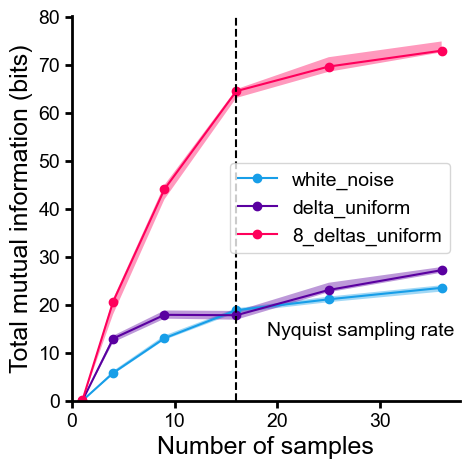

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():
    total_mi = np.array(mutual_information) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi, 'o-', label=object_name)
    ax.fill_between(num_samples_list, np.array(mi_by_object_lo[object_name]) * np.array(num_samples_list), 
                            np.array(mi_by_object_hi[object_name]) * np.array(num_samples_list), alpha=0.4)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])), xlim=(0, ax.get_xlim()[1]))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'mi_vs_sampling_density' + '.pdf', transparent=True)
